In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
from neuron_model import NeuronModel

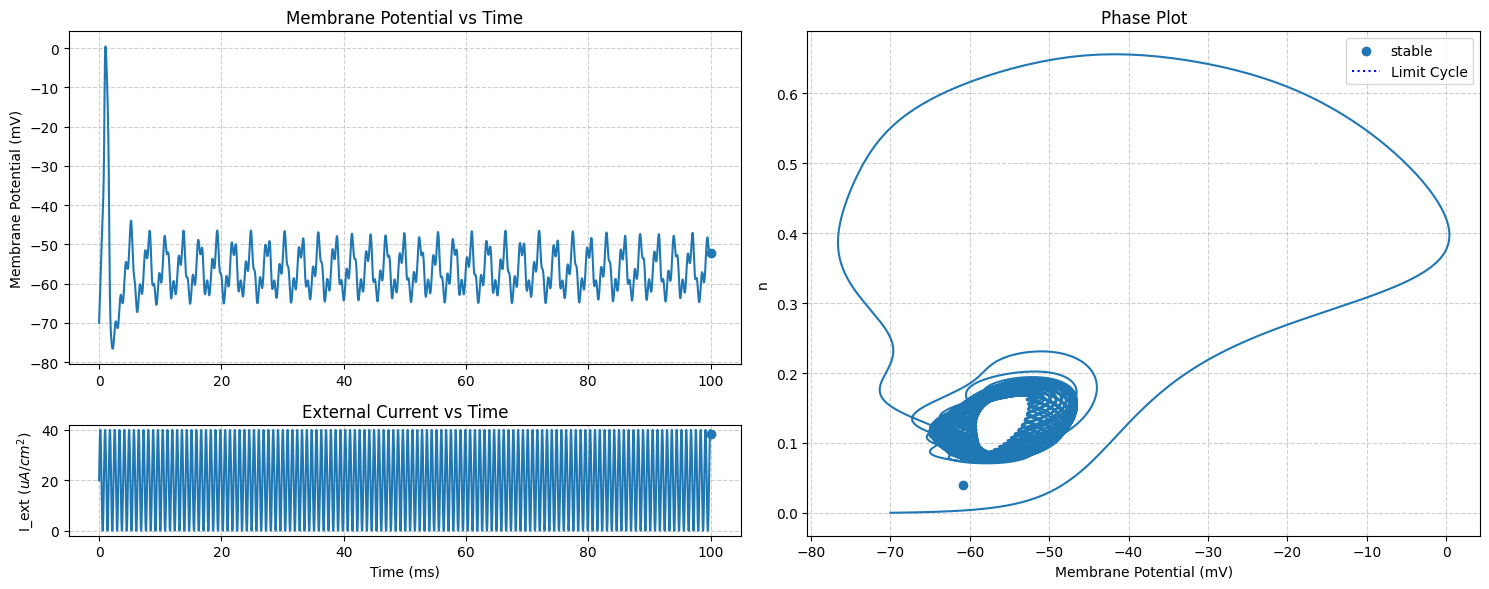

In [3]:
neuron = NeuronModel('supercritical_Hopf')    
dt = 0.01   
T = 100
t = np.arange(0, T, dt)
k = 8

# Creating different input currents
I_step = neuron.create_step_current(t, 10, 20, 0, 20)
I_ramp = neuron.create_ramp_current(t, 1, 10, 0, 5)
pulse_times = np.arange(0, 50, 7)
I_pulse = neuron.create_pulse_train(t, pulse_times, 1, 0, 50)
I_ext = 20*(np.sin(t*k) + 1)
a = neuron.simulate(T, dt, [-70, 0], I_ext)    

# Equilibria and limit cycle
equilibria = neuron.find_equlibrium_points(0, [-90, 20] )
limit_cycle = neuron.find_limit_cycle(1)

# --- Create Figure & Grid Layout ---
fig = plt.figure(figsize=(15, 6))
gs = gridspec.GridSpec(2, 2, height_ratios=[3, 1], width_ratios=[1, 1])

# --- Left Panel (Membrane Potential vs Time) ---
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_ylabel("Membrane Potential (mV)")
# ax1.set_xticks([])
# ax1.set_ylim([-80, 20])
ax1.set_title("Membrane Potential vs Time")
ax1.grid(True, linestyle="--", alpha=0.6)
line0, = ax1.plot(a[0][:], a[1][:, 0][:], marker = 'o', markevery = [-1])


# --- Right Panel (Phase Space Plot) ---
ax2 = fig.add_subplot(gs[:, 1])
ax2.set_xlabel("Membrane Potential (mV)")
ax2.set_ylabel("n")
ax2.set_title("Phase Plot")
# ax2.set_xlim([np.min(a[1][:, 0]) - 5, np.max(a[1][:, 0]) + 5])
# ax2.set_ylim([np.min(a[1][:, 1]) - 1, np.max(a[1][:, 1]) + 1])
ax2.grid(True, linestyle="--", alpha=0.6)
line1, = ax2.plot(a[1][:, 0], a[1][:, 1], marker = 'o', markevery = [-1])


# Equilibrium points
for eq in equilibria:
    ax2.scatter(eq['point'][0], eq['point'][1], label=eq['stability'], zorder=3)
ax2.plot(limit_cycle[0], limit_cycle[1], color='blue', linestyle=':', label='Limit Cycle')
ax2.legend()

# --- Bottom Panel (Current vs Time) ---
ax3 = fig.add_subplot(gs[1, 0])  # Takes full width
ax3.set_xlabel("Time (ms)")
ax3.set_ylabel("I_ext ($uA/cm^2$)")
ax3.set_title("External Current vs Time")
ax3.grid(True, linestyle="--", alpha=0.6)
line2, = ax3.plot(a[0], I_ext, marker = 'o', markevery = [-1])
# line2, = ax3.plot(a[0], I_ext(t), marker = 'o', markevery = [-1])

# --- Animation Update Function ---
def update(frame):
    # Membrane potential vs time
    line0.set_data(a[0][:frame], a[1][:, 0][:frame]) 

    # Phase space (V vs n)
    line1.set_data(a[1][:, 0][:frame], a[1][:, 1][:frame])

    # External current vs time
    # line2.set_data(a[0][:frame], I_ext(t[:frame]))
    line2.set_data(a[0][:frame], I_ext[:frame])

    return line0, line1, line2

# Create animation
# ani = animation.FuncAnimation(fig, update, frames=range(0, len(a[0]),5), interval=0.0001, blit=True)

plt.tight_layout()
plt.show()
from scipy.fft import fft, fftfreq


# Get membrane potential
V = a[1][:, 0]   # Assuming first dimension is membrane voltage
N=len(V)
# FFT
I_fft = np.abs(fft(I_ext))
V_fft = np.abs(fft(V))

# Frequencies
freqs = fftfreq(N, dt)

# Consider only positive frequencies
pos_mask = freqs >0
freqs_pos = freqs[pos_mask]
I_fft_pos = I_fft[pos_mask]


Peak frequency of I_ext: 0.08 kHz
Peak frequency of membrane potential: 0.32 kHz


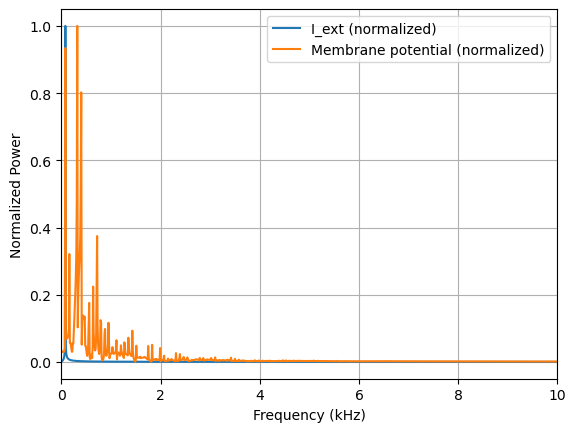

In [66]:
V_fft_pos = V_fft[pos_mask]

# Peak frequency
I_peak_freq = freqs_pos[np.argmax(I_fft_pos)]
V_peak_freq = freqs_pos[np.argmax(V_fft_pos)]

print(f"Peak frequency of I_ext: {I_peak_freq:.2f} kHz")
print(f"Peak frequency of membrane potential: {V_peak_freq:.2f} kHz")

# Optional plot
plt.plot(freqs_pos, I_fft_pos / max(I_fft_pos), label="I_ext (normalized)")
plt.plot(freqs_pos, V_fft_pos / max(V_fft_pos), label="Membrane potential (normalized)")
plt.xlabel("Frequency (kHz)")
plt.ylabel("Normalized Power")
plt.xlim(0,10)
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Time settings
dt = 0.01
T = 100
t = np.arange(0, T, dt)
N = len(t)
neuron = NeuronModel('supercritical_Hopf')  
# Storage
k_values = np.logspace(-4, 4, 30, base = 2)     # 20 values between 0.5 and 5
peak_freqs_V = []                      # For peak frequency of membrane potential
max_voltages = []                      # For max membrane voltage

# Loop over different values of k
for k in k_values:
    # Define external current
    I_ext = 20 * (np.sin(t*k) + 1)
    
    # Simulate neuron
    a = neuron.simulate(T, dt, [-70, 0], I_ext)
    
    # Extract membrane voltage trace
    V = a[1][:, 0]
    
    # FFT to find frequency peak
    V_fft = np.abs(fft(V))
    freqs = fftfreq(N, dt)
    pos_mask = freqs > 0
    freqs_pos = freqs[pos_mask]
    V_fft_pos = V_fft[pos_mask]
    V_peak_freq = freqs_pos[np.argmax(V_fft_pos)]
    settle_index = int(20 / dt)  # skip first 50 ms
    V_settled = V[settle_index:]

    # Find max voltage
    V_max = np.max(V_settled)
    
    # Store results
    peak_freqs_V.append(V_peak_freq)
    max_voltages.append(V_max)

# Convert to arrays for easier plotting
peak_freqs_V = np.array(peak_freqs_V)
max_voltages = np.array(max_voltages)


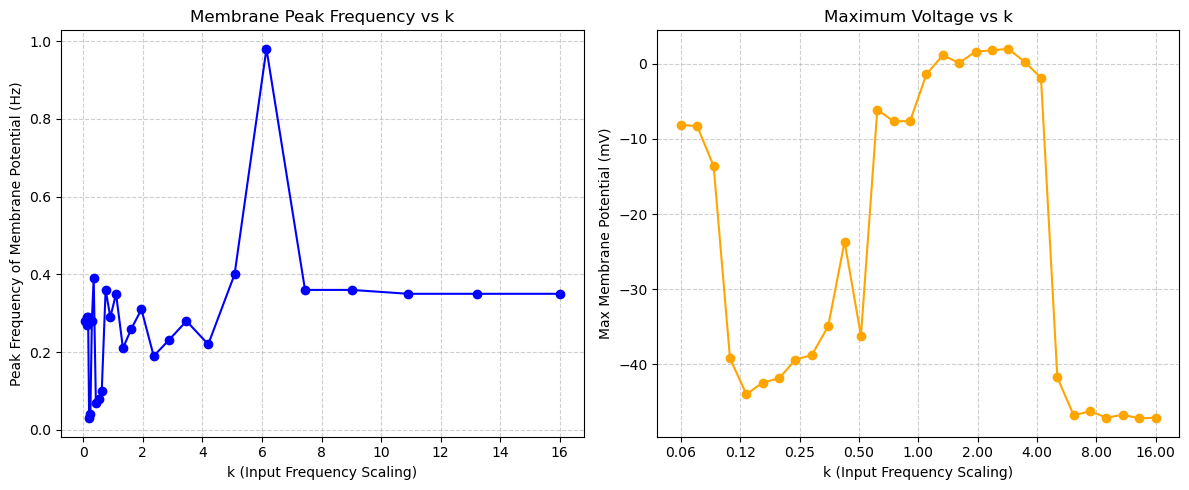

In [75]:
import matplotlib.ticker as ticker

# Plot: Frequency vs k
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_values, peak_freqs_V, marker='o', color='blue')
# plt.xscale('log', base=2)
plt.xlabel("k (Input Frequency Scaling)")
plt.ylabel("Peak Frequency of Membrane Potential (Hz)")
plt.title("Membrane Peak Frequency vs k")
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter())  # cleaner ticks

# Plot: Max Voltage vs k
plt.subplot(1, 2, 2)
plt.plot(k_values, max_voltages, marker='o', color='orange')
plt.xscale('log', base=2)
plt.xlabel("k (Input Frequency Scaling)")
plt.ylabel("Max Membrane Potential (mV)")
plt.title("Maximum Voltage vs k")
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter())  # cleaner ticks

plt.tight_layout()
plt.show()


In [28]:
# Time settings
dt = 0.01
T = 100
t = np.arange(0, T, dt)
N = len(t)
neuron = NeuronModel('subcritical_Hopf')  
# Storage
k_values = np.logspace(-4, 4, 30, base = 2)     # 20 values between 0.5 and 5
peak_freqs_V = []                      # For peak frequency of membrane potential
max_voltages = []                      # For max membrane voltage

# Loop over different values of k
for k in k_values:
    # Define external current
    I_ext = 20 * (np.sin(t*k) + 1)
    
    # Simulate neuron
    a = neuron.simulate(T, dt, [-70, 0], I_ext)
    
    # Extract membrane voltage trace
    V = a[1][:, 0]
    
    # FFT to find frequency peak
    V_fft = np.abs(fft(V))
    freqs = fftfreq(N, dt)
    pos_mask = freqs > 0
    freqs_pos = freqs[pos_mask]
    V_fft_pos = V_fft[pos_mask]
    V_peak_freq = freqs_pos[np.argmax(V_fft_pos)]
    settle_index = int(20 / dt)  # skip first 50 ms
    V_settled = V[settle_index:]

    # Find max voltage
    V_max = np.max(V_settled)
    
    # Store results
    peak_freqs_V.append(V_peak_freq)
    max_voltages.append(V_max)

# Convert to arrays for easier plotting
peak_freqs_V = np.array(peak_freqs_V)
max_voltages = np.array(max_voltages)

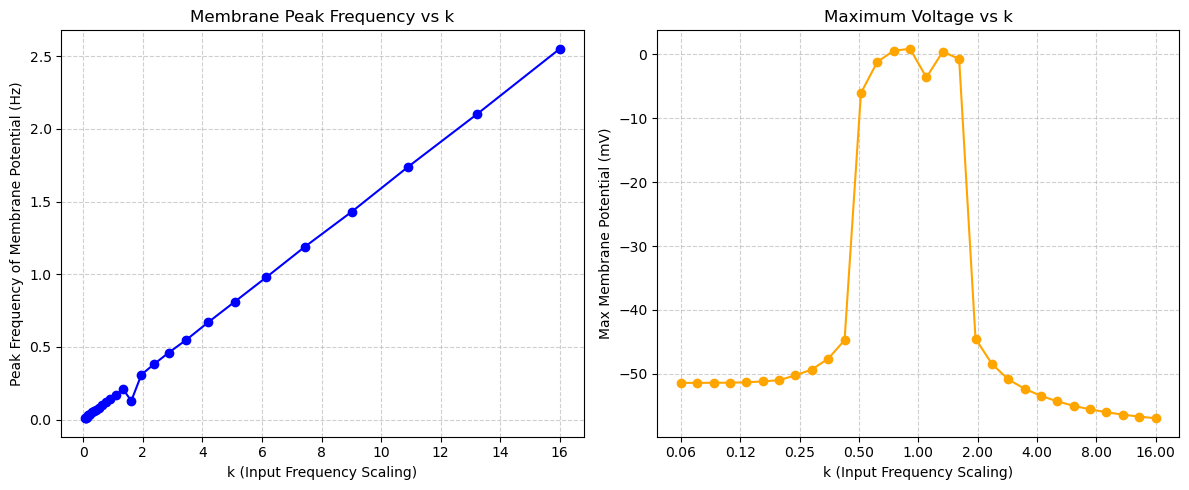

In [30]:
import matplotlib.ticker as ticker

# Plot: Frequency vs k
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_values, peak_freqs_V, marker='o', color='blue')
# plt.xscale('log', base=2)
plt.xlabel("k (Input Frequency Scaling)")
plt.ylabel("Peak Frequency of Membrane Potential (Hz)")
plt.title("Membrane Peak Frequency vs k")
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter())  # cleaner ticks

# Plot: Max Voltage vs k
plt.subplot(1, 2, 2)
plt.plot(k_values, max_voltages, marker='o', color='orange')
plt.xscale('log', base=2)
plt.xlabel("k (Input Frequency Scaling)")
plt.ylabel("Max Membrane Potential (mV)")
plt.title("Maximum Voltage vs k")
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter())  # cleaner ticks

plt.tight_layout()
plt.show()

In [57]:
# Time settings
dt = 0.01
T = 200
t = np.arange(0, T, dt)
N = len(t)
neuron = NeuronModel('saddle_node')  
# Storage
k_values = np.logspace(-2, 4, 30, base = 2)     # 20 values between 0.5 and 5
peak_freqs_V = []                      # For peak frequency of membrane potential
max_voltages = []                      # For max membrane voltage

# Loop over different values of k
for k in k_values:
    # Define external current
    I_ext = 5 * (np.sin(t*k) + 1)
    
    # Simulate neuron
    a = neuron.simulate(T, dt, [-70, 0], I_ext)
    
    # Extract membrane voltage trace
    V = a[1][:, 0]
    
    # FFT to find frequency peak
    V_fft = np.real(fft(V))
    freqs = fftfreq(N, dt)
    pos_mask = freqs > 0
    freqs_pos = freqs[pos_mask]
    V_fft_pos = V_fft[pos_mask]
    V_peak_freq = freqs_pos[np.argmax(V_fft_pos)]
    settle_index = int(20 / dt)  # skip first 50 ms
    V_settled = V[settle_index:]

    # Find max voltage
    V_max = np.max(V_settled)
    
    # Store results
    peak_freqs_V.append(V_peak_freq)
    max_voltages.append(V_max)

# Convert to arrays for easier plotting
peak_freqs_V = np.array(peak_freqs_V)
max_voltages = np.array(max_voltages)

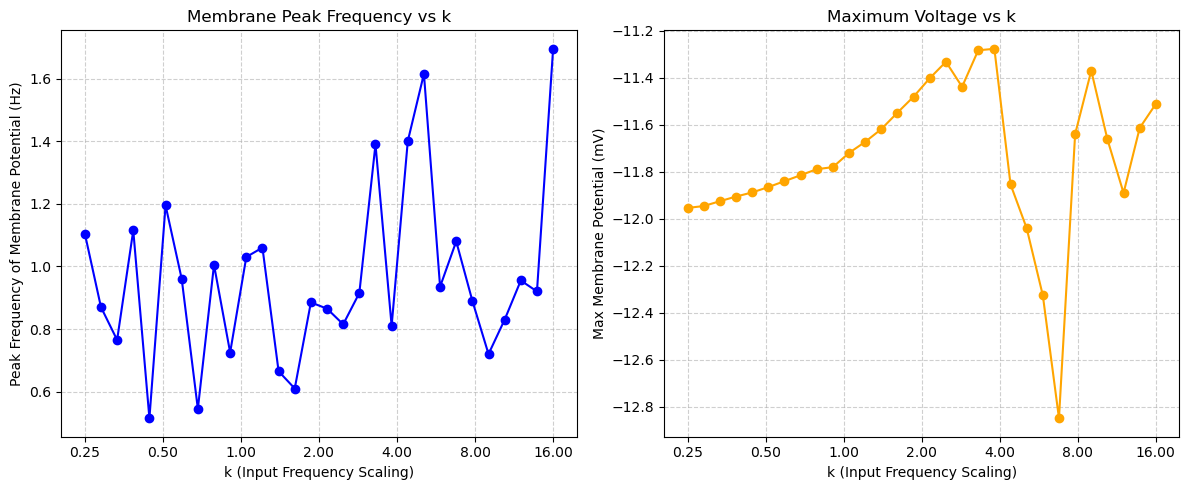

In [58]:
import matplotlib.ticker as ticker

# Plot: Frequency vs k
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_values, peak_freqs_V, marker='o', color='blue')
plt.xscale('log', base=2)
plt.xlabel("k (Input Frequency Scaling)")
plt.ylabel("Peak Frequency of Membrane Potential (Hz)")
plt.title("Membrane Peak Frequency vs k")
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter())  # cleaner ticks

# Plot: Max Voltage vs k
plt.subplot(1, 2, 2)
plt.plot(k_values, max_voltages, marker='o', color='orange')
plt.xscale('log', base=2)
plt.xlabel("k (Input Frequency Scaling)")
plt.ylabel("Max Membrane Potential (mV)")
plt.title("Maximum Voltage vs k")
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter())  # cleaner ticks

plt.tight_layout()
plt.show()